# pomegranate and parallelization

pomegranate supports parallelization through a set of built in functions based off of joblib. All computationally intensive functions in pomegranate are implemented in cython with the global interpreter lock (GIL) released, allowing for multithreading to be used for efficient parallel processing. The following functions can be called for parallelization:

1. fit
2. summarize
3. predict
4. predict_proba
5. predict_log_proba
6. log_probability
7. probability

These wrappers are all fairly simple, just chunking the data and passing them into the appropriate function. Any of the models in pomegranate can use them to varying degrees of efficiency. These functions work best when you have large amounts of data requiring several seconds (preferably more than 10) to process on a single processor. This is because it takes some time to set up the worker pool, and the parallelization is still being imporved.

In this tutorial, I will show you how you can use the parallelization wrappers to speed up fitting and predictions in models of increasing complexity. First we'll look at a simple multivariate Gaussian mixture model, and compare its performance to sklearn. Then we'll look at the first layer of model stacking that pomegranate supports by showing a hidden Markov model with GMM emissions, known as a GMM-HMM. Lastly, we'll go to the second layer of model stacking by showing a mixture of GMM-HMMs, which is a mixture model stacked inside a hidden markov model stacked inside a mixture model. These can all utilize the build-in parallelization functions that pomegranate has.

Let's dive right in!

In [1]:
%pylab inline
from sklearn.mixture import GMM
from pomegranate import *
import seaborn, time
seaborn.set_style('whitegrid')

Populating the interactive namespace from numpy and matplotlib


/home/jmschr/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
def create_dataset(n_samples, n_dim, n_classes, alpha=1):
    """Create a random dataset with n_samples in each class."""
    
    X = numpy.concatenate([numpy.random.normal(i*alpha, 1, size=(n_samples, n_dim)) for i in range(n_classes)])
    y = numpy.concatenate([numpy.zeros(n_samples) + i for i in range(n_classes)])
    idx = numpy.arange(X.shape[0])
    numpy.random.shuffle(idx)
    return X[idx], y[idx]

## 1. General Mixture Models

pomegranate has a very efficient implementation of mixture models, particularly Gaussian mixture models. Lets take a look at how fast pomegranate is versus sklearn, and then see how much faster parallelization can get it to be.

In [3]:
n, d, k = 1000000, 5, 3
X, y = create_dataset(n, d, k)

print "sklearn GMM"
%timeit GMM(n_components=k, covariance_type='full', n_iter=15, tol=1e-10).fit(X)
print 
print "pomegranate GMM"
%timeit fit(GeneralMixtureModel(MultivariateGaussianDistribution, n_components=k), X, max_iterations=15, stop_threshold=1e-10)
print
print "pomegranate GMM (4 jobs)"
%timeit fit(GeneralMixtureModel(MultivariateGaussianDistribution, n_components=k), X, n_jobs=4, max_iterations=15, stop_threshold=1e-10)

sklearn GMM
1 loop, best of 3: 1min 25s per loop

pomegranate GMM
1 loop, best of 3: 29.1 s per loop

pomegranate GMM (4 jobs)
1 loop, best of 3: 15.1 s per loop


It looks like on a large dataset not only is pomegranate faster than sklearn at performing 15 iterations of EM on 3 million 5 dimensional datapoints with 3 clusters, but the parallelization is able to help in speeding things up. 

Lets now take a look at the time it takes to make predictions using GMMs. Lets fit the model to a small amount of data, and then predict a larger amount of data drawn from the same underlying distributions.

In [4]:
d, k = 25, 2
X, y = create_dataset(1000, d, k)
a = GMM(k, n_init=1, n_iter=25).fit(X)
b = GeneralMixtureModel(MultivariateGaussianDistribution, n_components=k)
b.fit(X, max_iterations=25)

134.54620143746433

In [5]:
del X, y
n = 1000000
X, y = create_dataset(n, d, k)

print "sklearn GMM"
%timeit -n 1 a.predict_proba(X)
print
print "pomegranate GMM"
%timeit -n 1 b.predict_proba(X)
print
print "pomegranate GMM (4 jobs)"
%timeit -n 1 predict_proba(b, X, n_jobs=4)

sklearn GMM
1 loop, best of 3: 1.05 s per loop

pomegranate GMM
1 loop, best of 3: 1.2 s per loop

pomegranate GMM (4 jobs)
1 loop, best of 3: 749 ms per loop


It looks like pomegranate can be slightly slower than sklearn when using a single processor, but that it can be parallelized to get faster performance. At the same time, predictions at this level happen so quickly (millions per second) that this may not be the most reliable test for parallelization.

To ensure that we're getting the exact same results just faster, lets subtract the predictions from each other and make sure that the sum is equal to 0.

In [6]:
print (b.predict_proba(X) - predict_proba(b, X, n_jobs=4)).sum()

0.0


Great, no difference between the two.

Lets now make sure that pomegranate and sklearn are learning basically the same thing. Lets fit both models to some 2 dimensional 2 component data and make sure that they both extract the underlying clusters by plotting them.

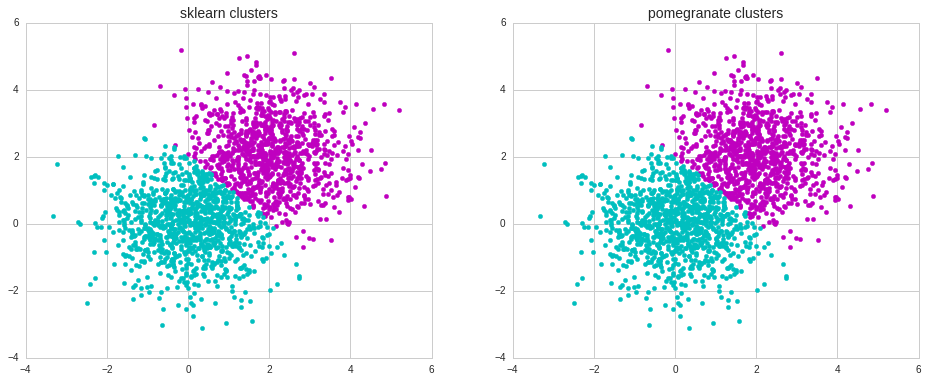

In [7]:
d, k = 2, 2
X, y = create_dataset(1000, d, k, alpha=2)
a = GMM(k, n_init=1, n_iter=25).fit(X)
b = GeneralMixtureModel(MultivariateGaussianDistribution, n_components=k)
b.fit(X, max_iterations=25)

y1, y2 = a.predict(X), b.predict(X)

plt.figure(figsize=(16,6))
plt.subplot(121)
plt.title("sklearn clusters", fontsize=14)
plt.scatter(X[y1==0, 0], X[y1==0, 1], color='m', edgecolor='m')
plt.scatter(X[y1==1, 0], X[y1==1, 1], color='c', edgecolor='c')

plt.subplot(122)
plt.title("pomegranate clusters", fontsize=14)
plt.scatter(X[y2==0, 0], X[y2==0, 1], color='m', edgecolor='m')
plt.scatter(X[y2==1, 0], X[y2==1, 1], color='c', edgecolor='c')

It looks like we're getting the same basic results for the two. The two algorithms are initialized a bit differently, and so it can be difficult to directly compare the results between them, but it looks like they're getting roughly the same results.

## 3. GMM-HMM

Sometimes a hidden Markov model will have emissions which are not just a simple distribution, but rather a mixture of these distributions. Frequently this is a mixture of Gaussian distributions, and so the term GMM-HMM refers to a Gaussian Mixture Model HMM. pomegranate does support arbitrary mixtures of any type of distributions instead of just Gaussians, but lets use multivariate gaussians in this case. The HMM structure will follow that of a "profile HMM" with randomly generated emissions to show that it is simple to parallelize even stacked models.

In [8]:
def create_profile_hmm(distributions, insert):
    i0 = State(insert, name="i0")
   
    model = HiddenMarkovModel()
    model.add_state(i0)
    model.add_transition(model.start, i0, 0.10)
    model.add_transition(i0, i0, 0.30)
    
    last_insert = i0
    last_delete = None
    last_match = model.start
    
    for i in range(1, len(distributions)+1):
        ii = State(insert, name="i{}".format(i))
        di = State(None, name="d{}".format(i))
        mi = State(distributions[i-1], name="m{}".format(i))
        
        model.add_states(ii, di, mi)
        model.add_transition(last_insert, mi, 0.60)
        model.add_transition(last_insert, di, 0.10)
        model.add_transition(ii, ii, 0.30)
        
        model.add_transition(last_match, mi, 0.80)
        model.add_transition(last_match, di, 0.10)
        model.add_transition(mi, ii, 0.10)
        
        if i > 1:
            model.add_transition(last_delete, mi, 0.70)
            model.add_transition(last_delete, di, 0.30)
        
        last_insert, last_delete, last_match = ii, di, mi
        
    model.add_transition(di, model.end, 1.0)
    model.add_transition(ii, model.end, 0.7)
    model.add_transition(mi, model.end, 0.9)
    model.bake()
    return model

def create_model(mus):
    d = mus.shape[1]
    distributions = [ GeneralMixtureModel([ MultivariateGaussianDistribution(mu, numpy.eye(d)),
                                            MultivariateGaussianDistribution(mu, numpy.eye(d)*3) ] 
                                         ) for mu in mus ]

    model = create_profile_hmm(distributions, MultivariateGaussianDistribution(numpy.zeros(d), numpy.eye(d)))
    return model

n, d = 100, 5
mus = (numpy.random.randn(d, n) + numpy.random.randn(n)*15).T

In [9]:
model = create_model(mus)
X = [model.sample() for i in range(100)]

print "pomegranate GMM-HMM (1 job)"
%timeit fit(model, X, max_iterations=5, verbose=False)
print
print "pomegranate GMM-HMM (4 jobs)"
model = create_model(mus)
%timeit fit(model, X, max_iterations=5, verbose=False, n_jobs=4)

pomegranate GMM-HMM (1 job)
1 loop, best of 3: 17.6 s per loop

pomegranate GMM-HMM (4 jobs)
1 loop, best of 3: 3.95 s per loop


All we had to do was pass in the n_jobs parameter to the fit function in order to get a speed improvement. It looks like we're getting a really good speed improvement, as well! This is mostly because the HMM algorithms perform a lot more operations than the other models, and so spend the vast majority of time with the GIL released.

Now lets look at the prediction function to make sure the we're getting speedups there as well.

In [10]:
model = create_model(mus)
X = [model.sample() for i in range(500)]

print "pomegranate GMM-HMM (1 job)"
%timeit predict_proba(model, X)
print
print "pomegranate GMM-HMM (4 jobs)"
%timeit predict_proba(model, X, n_jobs=4)

pomegranate GMM-HMM (1 job)
1 loop, best of 3: 12.3 s per loop

pomegranate GMM-HMM (4 jobs)
1 loop, best of 3: 5.19 s per loop


Great, we're getting a really good speedup on that as well! Looks like the parallel processing is more efficient with a bigger, more complex model, than with a simple one. This can make sense, because all inference/training is more complex, and so there is more time with the GIL released compared to with the simpler operations.

## 4. Mixture of Hidden Markov Models

Let's stack another layer onto this model by making it a mixture of these GMM-HMMs, instead of a single one. At this point we now are stacking a mixture model in a hidden Markov model into a mixture model again, and now we're going to train this big thing in parallel.

In [23]:
def create_mixture(mus):
    hmms = [create_model(mu) for mu in mus]
    return GeneralMixtureModel(hmms)

n, d = 50, 5
mus = [(numpy.random.randn(d, n)*0.2 + numpy.random.randn(n)*2).T for i in range(2)]

In [25]:
model = create_mixture(mus)
X = [model.sample() for i in range(250)]

print "pomegranate GMM-HMM-GMM (1 job)"
%timeit fit(model, X, max_iterations=5)
print

model = create_mixture(mus)
print "pomegranate GMM-HMM-GMM (4 jobs)"
%timeit fit(model, X, max_iterations=5, n_jobs=4)

pomegranate GMM-HMM-GMM (1 job)
1 loop, best of 3: 22.8 s per loop

pomegranate GMM-HMM-GMM (4 jobs)
1 loop, best of 3: 10.9 s per loop


Looks like we're getting a really nice speed improvement when training this complex model. Let's take a look now at the time it takes to do inference with it.

In [26]:
model = create_mixture(mus)
X = [model.sample() for i in range(500)]

print "pomegranate GMM-HMM-GMM (1 job)"
%timeit predict_proba(model, X)
print

model = create_mixture(mus)
print "pomegranate GMM-HMM-GMM (4 jobs)"
%timeit predict_proba(model, X, n_jobs=4)

pomegranate GMM-HMM-GMM (1 job)
1 loop, best of 3: 2.32 s per loop

pomegranate GMM-HMM-GMM (4 jobs)
1 loop, best of 3: 1.45 s per loop


We're getting a good speed improvement here too through parallelization.

## Conclusions

Hopefully you'll find pomegranate useful in your work! These parallelization wrappers should allow you to train complex models faster than before. Keep in mind though that there is an overhead to using parallel processing, and so it's possible that on some smaller examples it does not work as well. In general, the bigger the dataset, the closer to a linear speedup you'll get with pomegranate.

If you have any interesting examples of how you've used pomegranate in your work, I'd love to hear about them. In addition I'd like to hear any feedback you may have on features you'd like to see. Please shoot me an email. Good luck!